In [1]:
import gpflow
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.append('../')
from GPHetero import hetero_kernels, hetero_likelihoods, hetero_gpmc

In [2]:
class Ex1Func(object):
    
    def __init__(self, sigma=lambda x: 0.5):
        self.sigma = sigma

    def __call__(self, x):
        
        if x[0] < 0.5:
            return x[0]**2. +  self.sigma(x[0]) * np.random.randn()
        if x[0] == 0.5:
            return 1.
        if x[0] > 0.5:
            return 2. - (x[0]-0.5) ** 2.

In [3]:
from pyDOE import *

/Users/piyushpandita/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


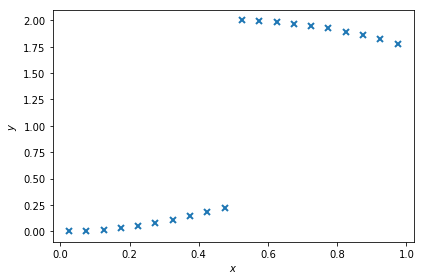

In [4]:
dim = 1
n = 20
noise=0
sigma = eval('lambda x: ' + str(noise))
objective = Ex1Func(sigma=sigma)
X = lhs(dim, n , criterion='center')
Y = np.array([objective(x) for x in X])[:, None]



#Xm = np.mean(X)
#Xv = np.std(X)
Xnorm = (X - 0.5) / 0.5

fig, ax = plt.subplots()
ax.plot(X, Y, 'x', markeredgewidth=2)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

In [7]:
print Y.shape

(20, 1)


In [8]:
#build the model
k = gpflow.kernels.RBF(input_dim=1)
nonstat = hetero_kernels.NonStationaryLengthscaleRBF()
m = hetero_gpmc.GPMCAdaptiveLengthscale2D(Xnorm, Y, k, nonstat)

In [9]:
m.kerns["ell0"].variance.prior = gpflow.priors.Gaussian(0, 1.)
m.kerns["ell0"].lengthscales.prior = gpflow.priors.Gaussian(0, 1.)
m.nonstat.signal_variance.prior = gpflow.priors.Gaussian(0, 1.)
m.likelihood.variance = 0.01
m.likelihood.variance.fixed = True

In [10]:
# m.optimize(maxiter=5000) # start near MAP

In [11]:
samples = m.sample(20, verbose=True, epsilon=0.00005, thin = 2, burn = 100, Lmax = 160)

burn-in sampling started
Iteration:  100 	 Acc Rate:  98.0 %
burn-in sampling ended


In [24]:
print samples.T.shape
sample_df = m.get_samples_df(samples)
print sample_df.shape
print Xnorm.shape

(43, 20)
(20, 6)
(20, 1)


In [31]:
sample_df = m.get_samples_df(samples)
xnew = np.linspace(0, 1, 50)[:,None]
xx = (xnew - 0.5) / 0.5
mean_f_mat = np.zeros(shape = (samples.T.shape[0], xx.shape[0]))
var_f_mat = np.zeros(shape = (samples.T.shape[0], xx.shape[0]))
meanx = []
varx = []
for i, s in sample_df.iterrows():
    m.set_parameter_dict(s)
    mean_f, var_f = m.predict_f(xx)
    mean_f_mat[i, :] = mean_f[:, 0]
    var_f_mat[i, :] = np.diag(var_f)
#     meanx.append(mean_f)
#     varx.append(np.diag(var_f))

In [32]:
std_f_mat = np.sqrt(var_f_mat)
Lowerf = mean_f_mat - 2 * std_f_mat
Upperf = mean_f_mat + 2 * std_f_mat

In [37]:
def visualize(Xgrid, Mgrid, Vargrid, noise_var):
    """
    Visualize 1D utility funciton values
    Xgrid : grid states
    Mgrid : mean of GP at those finite grid points
    Vargrid : variance of GP at those finite grid points
    """
    Std_noise = np.sqrt(noise_var)
#     signal_std = np.sqrt(signal_var)
 
    Stdgrid = np.sqrt(Vargrid)
    
    lower = Mgrid - 2*Stdgrid
    upper = Mgrid + 2*Stdgrid
    
    lower1 = lower - 2*Std_noise
    upper1 = upper + 2*Std_noise
    
    plt.plot(X, Y, '.')
    line, = plt.plot(Xgrid, Mgrid, lw = 2, color = 'b', label = 'utility', alpha = 0.5)
    plt.fill_between(Xgrid[:,0], lower, upper,
                     color = 'b', alpha = 0.05)
    #plt.fill_between(Xgrid[:,0], lower1, upper1,
    #                 color = 'g', alpha = 0.25)
    plt.xlabel('x')
    plt.ylabel('y')
    return

In [38]:
X_true = np.linspace(0, 1, 100)[:,None]
Y_true = np.array([objective(x) for x in X_true])[:, None]

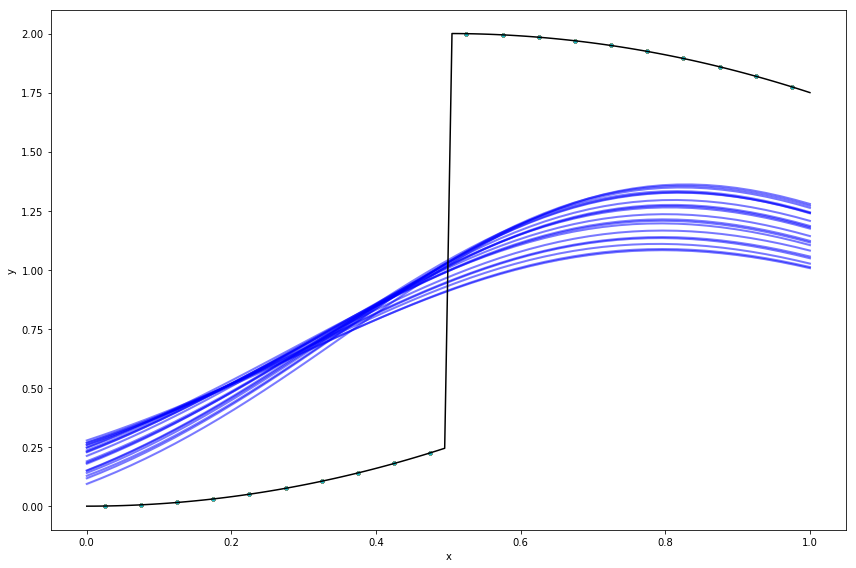

In [39]:
mini = 0
maxi = 20
plt.figure(figsize=(12,8))

for i in xrange(mini,maxi):
    visualize(xnew, mean_f_mat[i,:], var_f_mat[i,:], noise_var=1e-4)  
plt.plot(X_true, Y_true, 'k')

In [ ]:
def visualize_l(Xgrid, M, L, U):
    """
    Visualize 1D utility funciton values
    Xgrid : grid states
    Mgrid : mean of GP at those finite grid points
    Vargrid : variance of GP at those finite grid points
    """
    
    line, = plt.plot(Xgrid, M, lw = 2, color = 'b', label = 'utility', alpha = 0.5)
    plt.fill_between(Xgrid[:,0], L, U,
                     color = 'b', alpha = 0.25)
    #plt.fill_between(Xgrid[:,0], lower1, upper1,
    #                 color = 'g', alpha = 0.25)
    plt.xlabel('x')
    plt.ylabel('y')
    return

In [ ]:
mini = 100
maxi = 200
plt.figure(figsize=(12,8))
for i in xrange(mini,maxi):
    visualize_l(xnew, MeanL[i,:], LowerL[i,:], UpperL[i,:])  

In [ ]:
m.predict_f_samples(xx, 100).shape